# DATAIMPORT/ CLEANUP

In [84]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns
import numpy as np
import glob
from sklearn.preprocessing import MinMaxScaler
import scipy.stats as stats
from scipy.stats import levene
from itertools import pairwise
from summarytools import dfSummary



In [ ]:
path = r"C:\Users\cr\Downloads"

dfAll = pd.DataFrame()
for version in range(7):
    pattern = os.path.join(path, f"Version{version}_*{"1_1_true"}.txt")
    files = glob.glob(pattern)

    for file in files:
        df = pd.read_csv(file, header=0, names=["ObjInstance", "Identifier", "MethodName", "ElapsedMilliseconds"])
        df["Version"] = f"Version{version}"
        df = df.loc[df.groupby(["ObjInstance", "MethodName"])["ElapsedMilliseconds"].idxmax()]
        dfAll = pd.concat([dfAll, df], ignore_index=True)

output_path = os.path.join(r"D:\projects\private\Bachelorarbeit_Blazor_Wasm\BenchmarkResults", "dfAll_1_1_true.csv")
dfAll.to_csv(output_path, index=False, encoding="utf-8")


In [86]:
dfAll = dfAll.dropna(subset=["ElapsedMilliseconds"])
dfAll = dfAll.drop_duplicates(subset=["ObjInstance", "Identifier", "MethodName", "ElapsedMilliseconds"])

dfAll["ElapsedMilliseconds"] = pd.to_numeric(dfAll["ElapsedMilliseconds"])
dfAll = dfAll[dfAll["ElapsedMilliseconds"] >= 0]

#Reihenfolge für Plots
custom_order = [
    "SetParam",
    "SetParam_OnInit",
    "GenerateOrders",
    "PopulateChartOrderState",
    "OnInit_OnParam",
    "OnParam_OnAfterRender",
    "VisualizeOrderStatusSuccess",
    "FINISH"
]

lifecycle = [
    "SetParam",
    "SetParam_OnInit",
    "OnInit_OnParam",
    "OnParam_OnAfterRender",
    "FINISH"
]


dfAll["MethodName"] = pd.Categorical(dfAll["MethodName"], categories=custom_order, ordered=True)
#Um das Gruppieren zum umgehen und bei Plots nach Version und Komponente zu unterscheiden
dfAll["VersionObjInstance"] = dfAll["Version"].astype(str) + " - " + dfAll["ObjInstance"].astype(str)

dfLifecycle = dfAll[dfAll["MethodName"].isin(lifecycle)]
dfLifecycle["VersionObjInstance"] = dfAll["Version"].astype(str) + " - " + dfAll["ObjInstance"].astype(str)




C:\Users\cr\AppData\Local\Temp\ipykernel_20048\112715811.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfLifecycle["VersionObjInstance"] = dfAll["Version"].astype(str) + " - " + dfAll["ObjInstance"].astype(str)


# CHECK SIGNIFICANCE

## PLOT

C:\Users\cr\AppData\Local\Temp\ipykernel_20048\2333744434.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\2333744434.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\2333744434.py:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


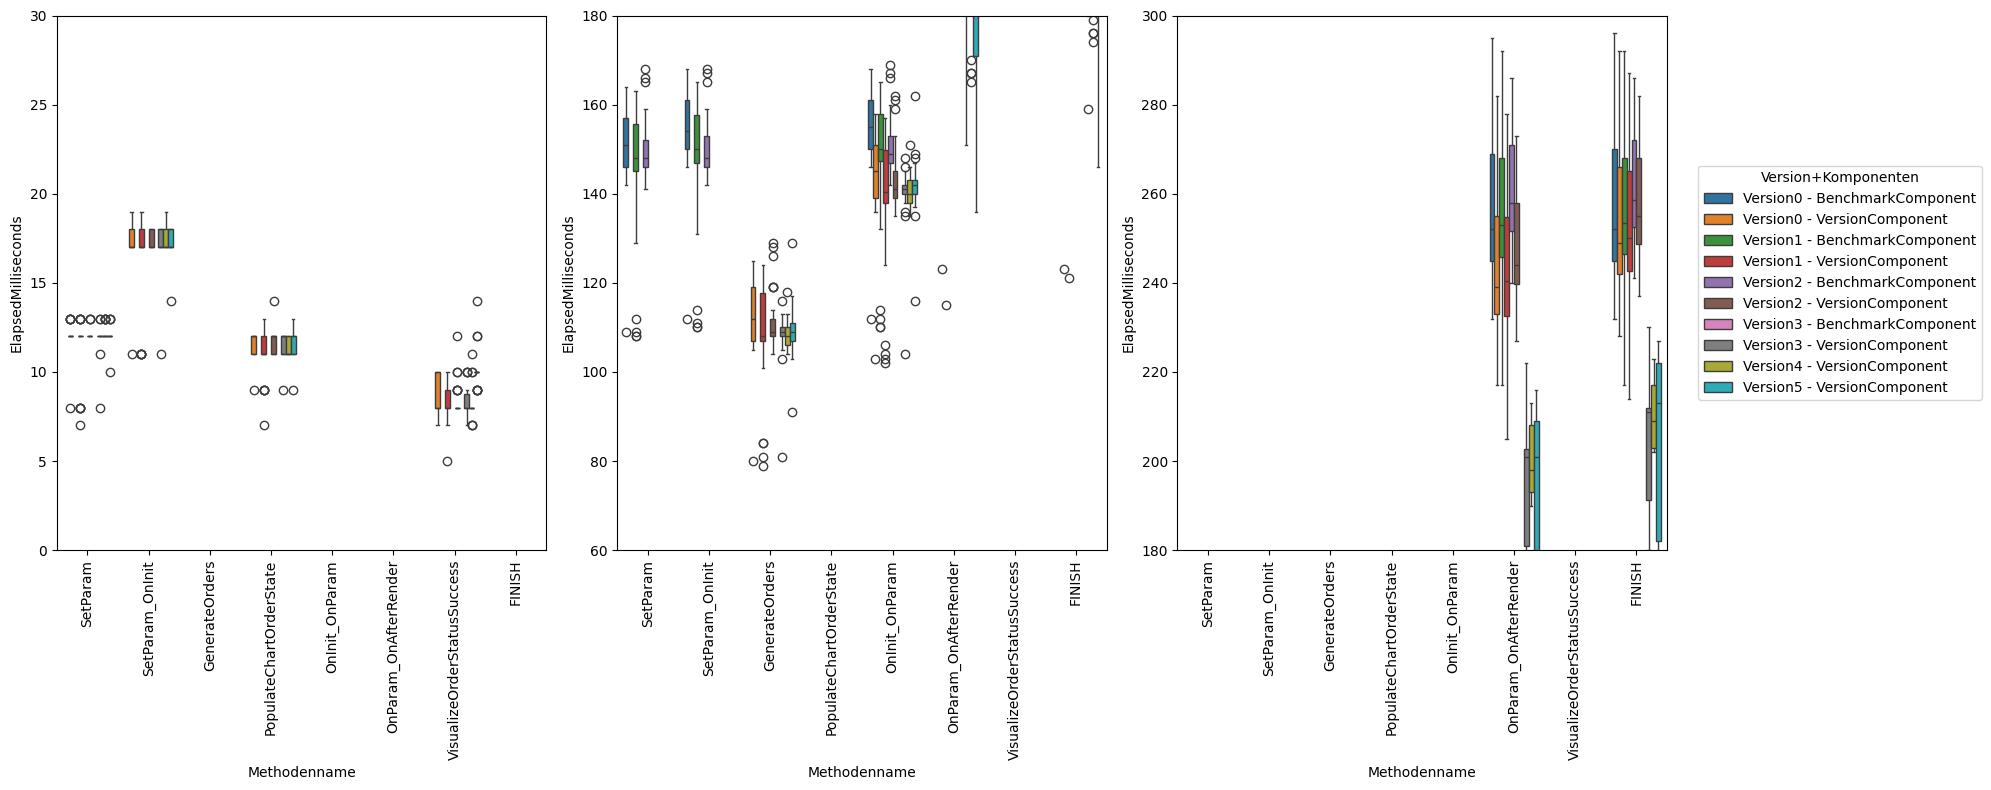

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax1, legend=False)
ax1.set_ylim(0, 30)

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax2 , legend=False)
ax2.set_ylim(60, 180)

sns.boxplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", ax=ax3)
ax3.set_ylim(180, 300)

for ax in [ax1, ax2, ax3]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.set_xlabel("Methodenname")
    ax.set_ylabel("ElapsedMilliseconds")

plt.legend(title="Version+Komponenten", bbox_to_anchor=(1.05, 0.5), loc="center left")

plt.tight_layout()
plt.show()


In [88]:
#chatgpt
def remove_outliers_grouped(df, value_col, group_cols, threshold=1.5):
    def filter_group(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        return group[(group[value_col] >= lower_bound) & (group[value_col] <= upper_bound)]
    
    return df.groupby(group_cols, group_keys=False).apply(filter_group)

dfAll = remove_outliers_grouped(dfAll, "ElapsedMilliseconds", ["MethodName", "VersionObjInstance"])


C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3837181942.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(filter_group)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3837181942.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(filter_group)


C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3990034774.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dfAll[dfAll["VersionObjInstance"] == VersionObjInstance],
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3990034774.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dfAll[dfAll["VersionObjInstance"] == VersionObjInstance],
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3990034774.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dfAll[dfAll["VersionObjInstance"] == VersionObjInstance],
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3990034774.py:13: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=dfAll[dfAll["VersionObjIns

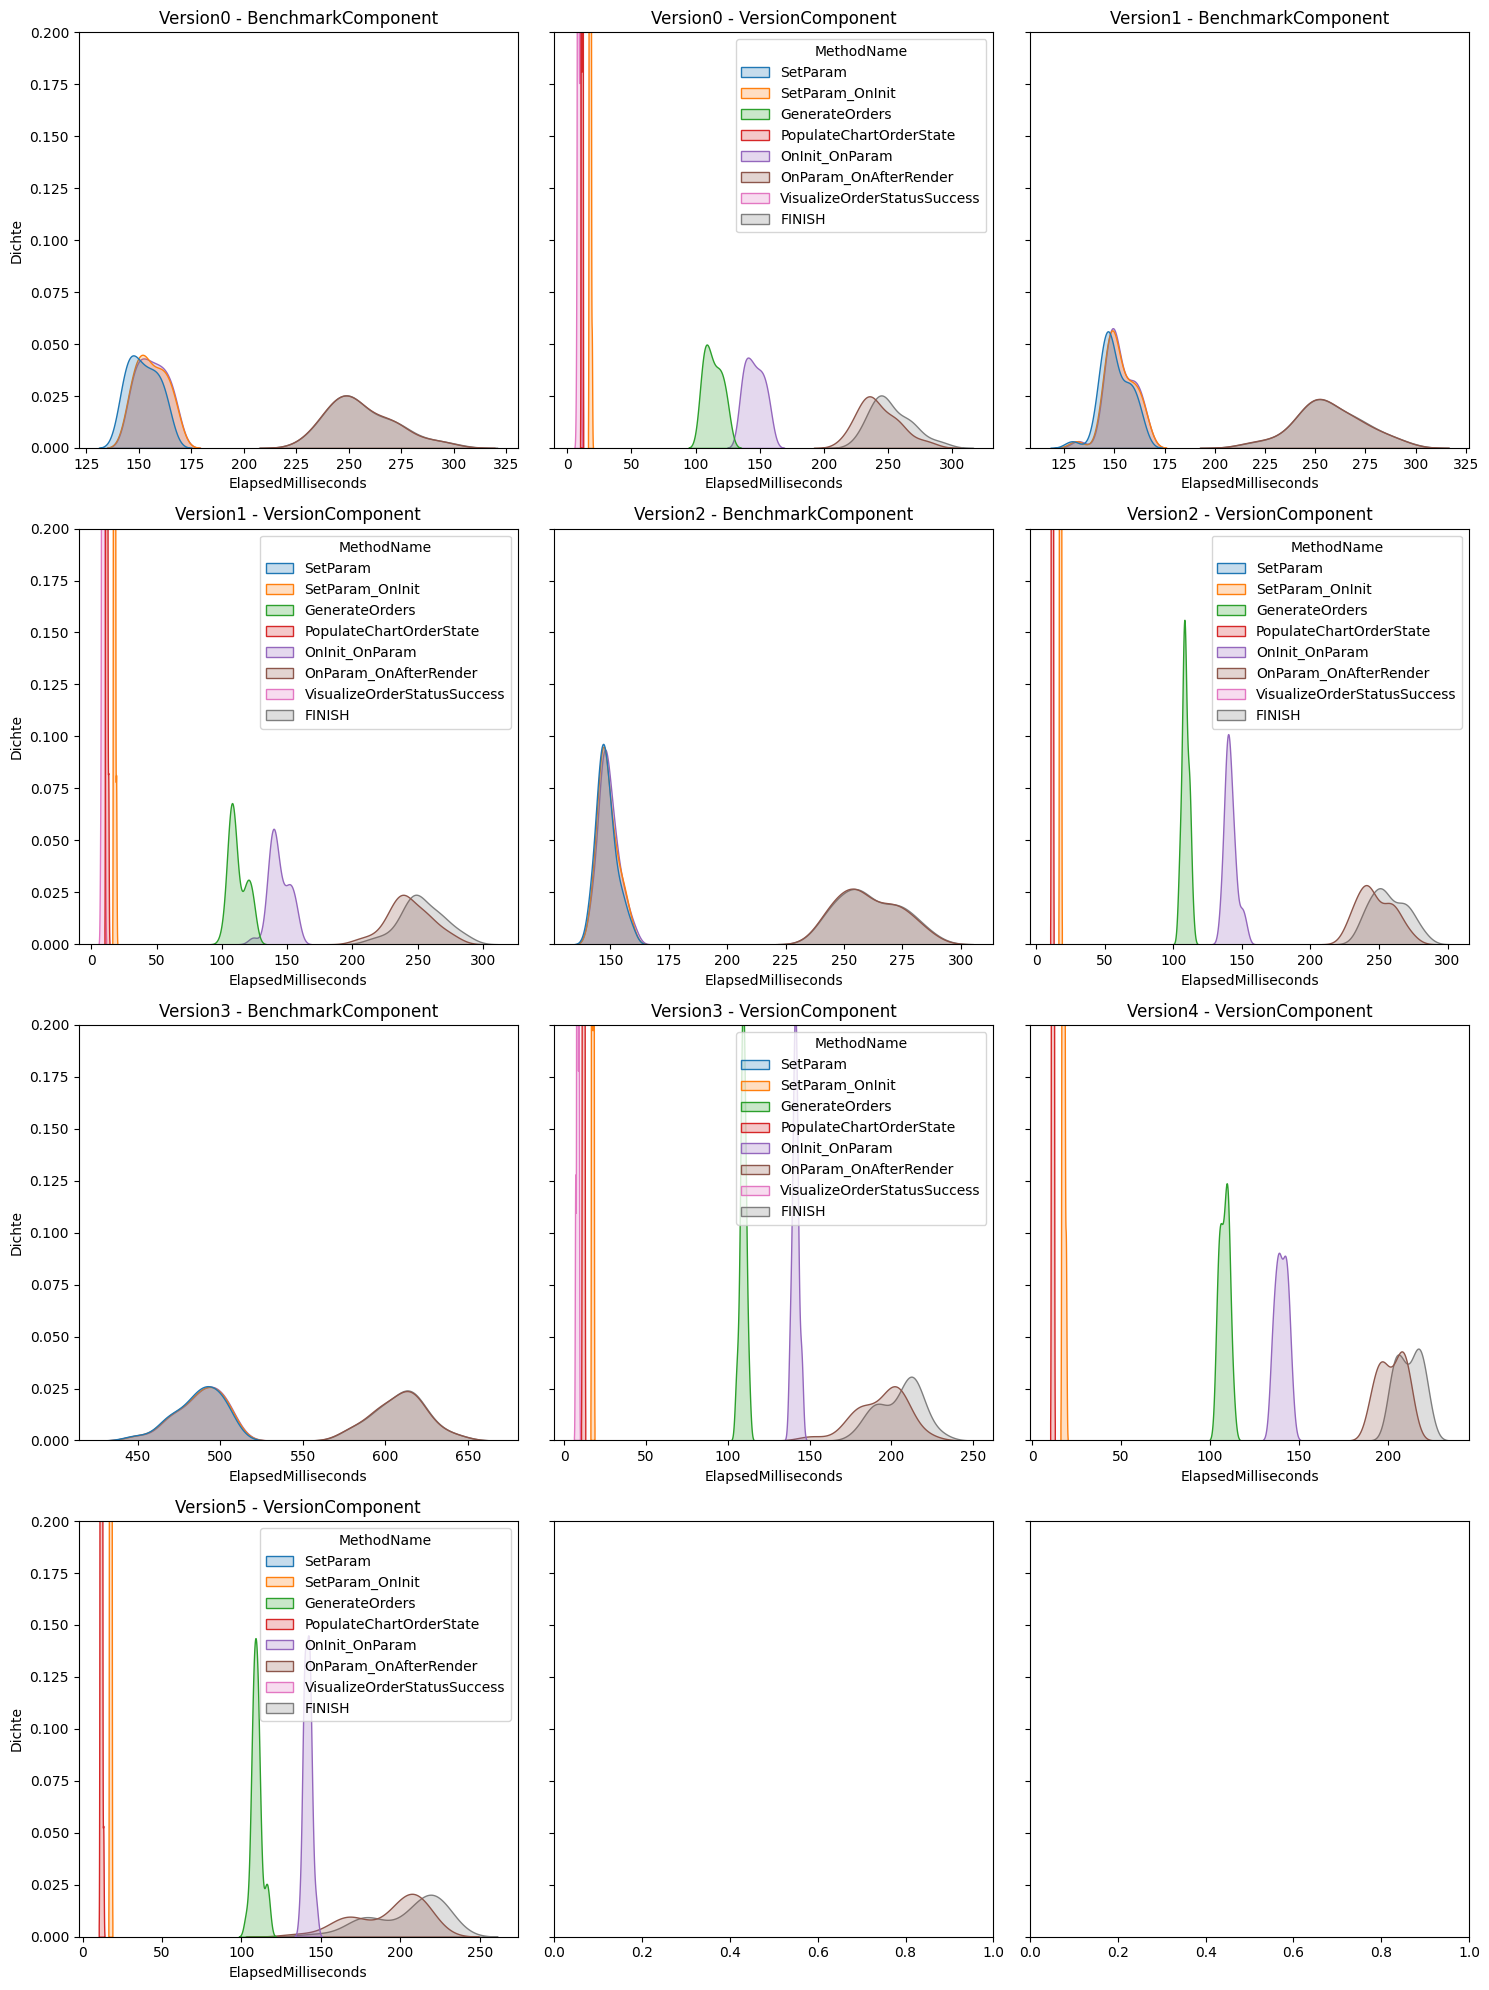

In [89]:
uniqueVersionObjInstances = dfAll["VersionObjInstance"].unique()

num_plots = len(uniqueVersionObjInstances)
num_cols = 3  
num_rows = (num_plots + num_cols - 1) // num_cols 

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharey=True)
axes = axes.flatten()  

for i, VersionObjInstance in enumerate(uniqueVersionObjInstances):
    ax = axes[i]
    
    sns.kdeplot(data=dfAll[dfAll["VersionObjInstance"] == VersionObjInstance], 
                x="ElapsedMilliseconds", 
                hue="MethodName", 
                fill=True, 
                common_norm=False, 
                legend=True if i % 2 else False,
                ax=ax)
    ax.set_title(f"{VersionObjInstance}")
    ax.set_xlabel("ElapsedMilliseconds")
    ax.set_ylabel("Dichte")
    ax.set_ylim(0, 0.2)

plt.tight_layout()
plt.show()



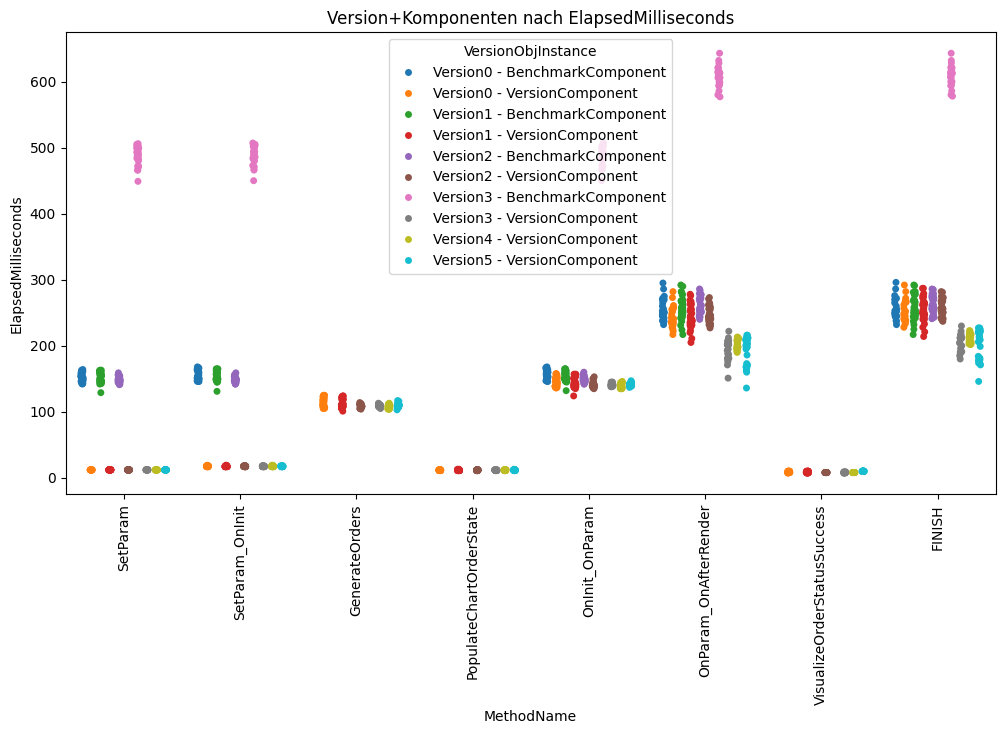

In [90]:
plt.figure(figsize=(12, 6))
sns.stripplot(data=dfAll, x="MethodName", y="ElapsedMilliseconds", hue="VersionObjInstance", dodge=True)
plt.xticks(rotation=90)
plt.title("Version+Komponenten nach ElapsedMilliseconds")
plt.show()

## CALCULATION

In [91]:
uniqueVersionObjInstances = dfAll["VersionObjInstance"].unique()
uniqueMethods = dfAll["MethodName"].unique()

for version in uniqueVersionObjInstances:
    versionObjIni = dfAll[dfAll["VersionObjInstance"] == version]
    
    for method in uniqueMethods:
        #Fehler, weil kindkomponente nur lifecyclemethoden hat
        if (method not in lifecycle and (versionObjIni["ObjInstance"] == "BenchmarkComponent").any()):
            continue

        data = versionObjIni[versionObjIni["MethodName"] == method]["ElapsedMilliseconds"]

        modeResult = stats.mode(data).mode
        median = data.median()
        mean = data.mean()
        
        skew = stats.skew(data)
        #unbiased ddof
        std = np.std(data, ddof=1) 

        if modeResult is not None:
            stdPercent = std / mean
            
            if stdPercent > 0.1:
                print(f"{version}, Method: {method}; Mode: {modeResult}; Median: {median}; Std: {std:.2f}")

            #if abs(skew) > 0.1:
                #print(f"{version}; Method: {method}; Skew: {skew:.2f}")


Version0 - VersionComponent, Method: VisualizeOrderStatusSuccess; Mode: 8; Median: 8.0; Std: 0.95
Version1 - VersionComponent, Method: VisualizeOrderStatusSuccess; Mode: 8; Median: 8.0; Std: 0.90
Version5 - VersionComponent, Method: OnParam_OnAfterRender; Mode: 209; Median: 201.0; Std: 21.89
Version5 - VersionComponent, Method: FINISH; Mode: 221; Median: 213.0; Std: 22.33


C:\Users\cr\AppData\Local\Temp\ipykernel_20048\4060226782.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(data)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\4060226782.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(data)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\4060226782.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(data)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\4060226782.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Resul

In [92]:
versions = [f"Version{i}" for i in range(7)]


for version in uniqueVersionObjInstances:
    for method in uniqueMethods:
        print(f"\n{version} - Methode: {method}")
    
        df_method = dfAll[dfAll["MethodName"] == method]
    
        for version_a, version_b in pairwise(versions):
            version_a_data = df_method[df_method["Version"] == version_a]["ElapsedMilliseconds"]
            version_b_data = df_method[df_method["Version"] == version_b]["ElapsedMilliseconds"]
        
            t_stat, p_value = stats.ttest_ind(version_a_data, version_b_data, equal_var=False)
            if p_value < 0.05:
                print(f"{version_b} und {version_a} welchs : t-statistic = {t_stat}, p-value = {p_value}")
        
            u_stat, p_value_u = stats.mannwhitneyu(version_a_data, version_b_data)
            if p_value_u < 0.05:
                print(f"{version_b} und {version_a} Mann : U-statistic = {u_stat}, p-value = {p_value_u}")


c:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\1365770282.py:14: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  t_stat, p_value = stats.ttest_ind(version_a_data, version_b_data, equal_var=False)
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\1365770282.py:18: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  u_stat, p_value_u = stats.mannwhitneyu(version_a_data, version_b_data)



Version0 - BenchmarkComponent - Methode: SetParam
Version3 und Version2 welchs : t-statistic = -5.107868044188679, p-value = 4.688792261606832e-06
Version3 und Version2 Mann : U-statistic = 957.0, p-value = 0.00547656940258943
Version4 und Version3 welchs : t-statistic = 7.223244669279383, p-value = 4.218887314405654e-09
Version4 und Version3 Mann : U-statistic = 720.0, p-value = 8.214874565586163e-05

Version0 - BenchmarkComponent - Methode: SetParam_OnInit
Version3 und Version2 welchs : t-statistic = -4.9765645852758755, p-value = 6.676695397871405e-06
Version3 und Version2 Mann : U-statistic = 1172.0, p-value = 0.03303979298875482
Version4 und Version3 welchs : t-statistic = 6.98888670237742, p-value = 6.900899863911655e-09
Version4 und Version3 Mann : U-statistic = 904.5, p-value = 0.0010290731172360272

Version0 - BenchmarkComponent - Methode: GenerateOrders
Version2 und Version1 welchs : t-statistic = 2.6126208397583977, p-value = 0.01222248073962479

Version0 - BenchmarkCompone

# DATA EXPLORATION

C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3404266072.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  dfTilt = dfAll.pivot_table(
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3404266072.py:1: FutureWarning: The provided callable <function median at 0x000001E9E736A700> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  dfTilt = dfAll.pivot_table(


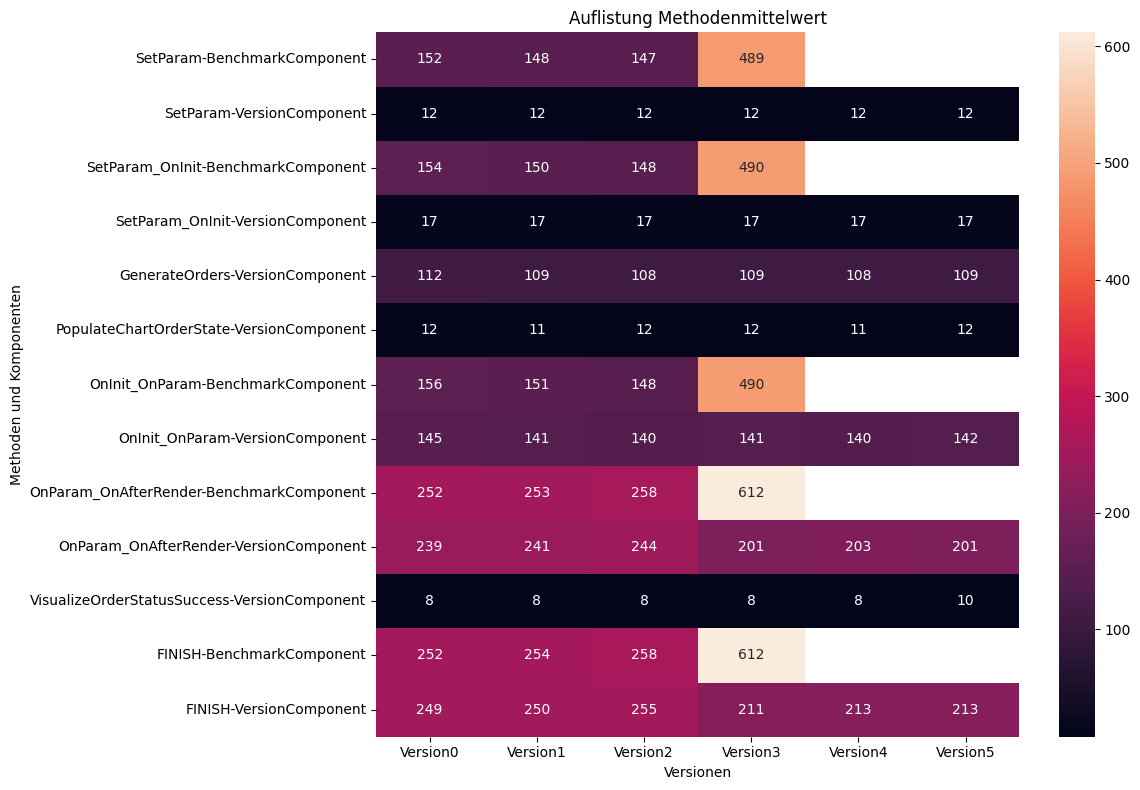

In [93]:
dfTilt = dfAll.pivot_table(
    values="ElapsedMilliseconds",
    index=["MethodName", "ObjInstance"],
    columns="Version",
    aggfunc=np.median
).sort_index(level=0)

plt.figure(figsize=(12, 8))
sns.heatmap(dfTilt, annot=True, fmt=".0f")

plt.title("Auflistung Methodenmittelwert")
plt.xlabel("Versionen")
plt.ylabel("Methoden und Komponenten")

plt.tight_layout()
plt.show()


C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3724445077.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = dfAll.pivot_table(
C:\Users\cr\AppData\Local\Temp\ipykernel_20048\3724445077.py:1: FutureWarning: The provided callable <function median at 0x000001E9E736A700> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_pivot = dfAll.pivot_table(


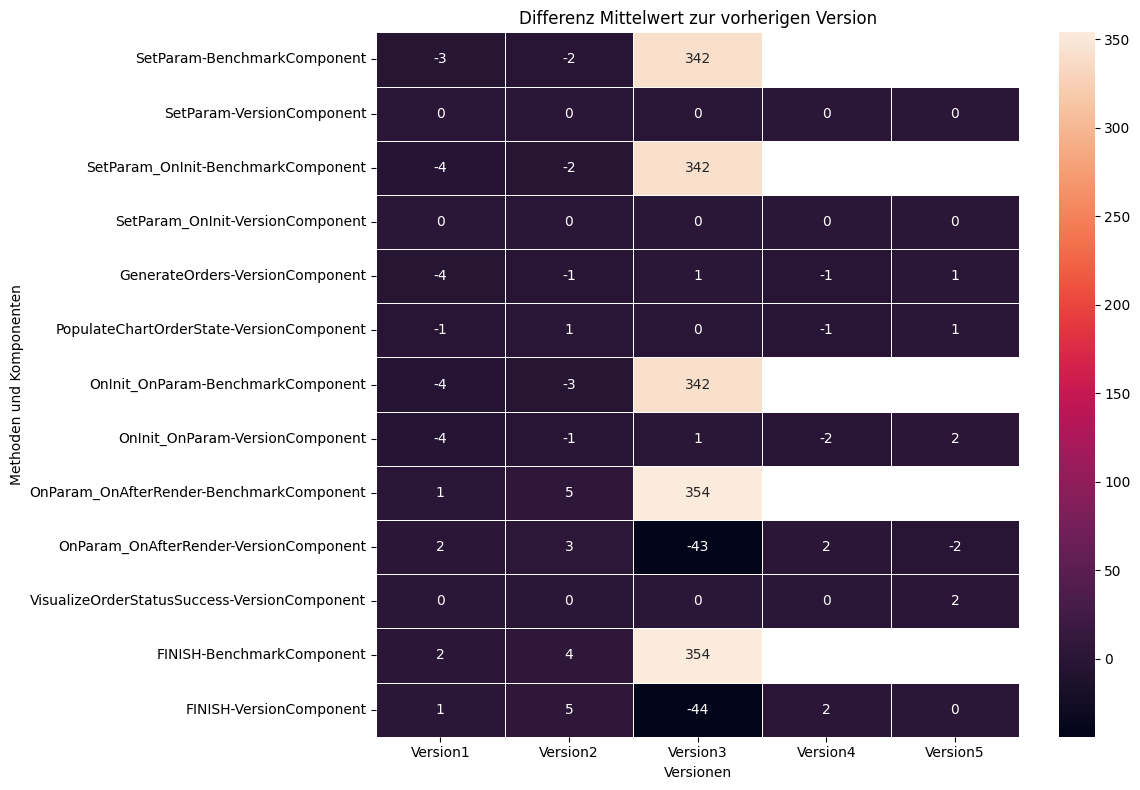

In [94]:
df_pivot = dfAll.pivot_table(
    values="ElapsedMilliseconds",
    index=["MethodName", "ObjInstance"],
    columns="Version",
    aggfunc=np.median
).sort_index(level=0)

df_diff = df_pivot.diff(axis=1).iloc[:, 1:]

plt.figure(figsize=(12, 8))
sns.heatmap(df_diff, annot=True, fmt=".0f", linewidths=0.5)

plt.title("Differenz Mittelwert zur vorherigen Version")
plt.xlabel("Versionen")
plt.ylabel("Methoden und Komponenten")

plt.tight_layout()
plt.show()
